In [1]:
import sys
import os
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter
from tqdm import tqdm
import pandas as pd
import matplotlib
import math

def statistic_data(raw_data, verbose=True):
    records = dict()
    total_rxn = 0; total_context = 0
    for reaction_name, data in raw_data.items():
        t_rxn = len(set(data['Reaction ID']))
        t_context = len(data)
        records.update({reaction_name: [t_rxn, t_context]})
        total_rxn += t_rxn
        total_context += t_context
        if verbose:
            print(reaction_name, t_rxn, t_context)
    if verbose:
        print("Total reactions:", total_rxn)
        print("Total contexts:", total_context)
    return records

In [2]:
# Get the number of each reaction set
reaxys_dir = "../data/reaxys_input/"
dir_names = ['Buchwald-HartwigCross-Coupling','Chan_LamCoupling','DielsAlder',
             'FischerIndoleSynthesis','Friedel-CraftsAcylation','Friedel-CraftsAlkylation',
             'GrignardReaction', 'KumadaCoupling', 'NegishiCoupling', 'ReductiveAmination'] # Change Here

def basic_preprocess(data_path):
    keep_index = ['Reaction ID', 'Reaction', 'Temperature (Reaction Details) [C]', 
                  'Yield (numerical)','Reagent', 'Solvent (Reaction Details)']
    data = pd.read_excel(data_path, engine="openpyxl")
    drop_index = list(data.columns)
    for index in list(data.columns):
        if index in keep_index:
            drop_index.remove(index)
    data = data.drop(drop_index,axis=1)
    data = data[:-3] # copyright or something 
    return data

def reaction_entry(reaction_ids):
    now = '0'
    number = 0
    for id_ in reaction_ids:
        if id_ != now:
            number += 1
            now = id_
    return number
            
records = dict()
raw_datas = dict()
    
file_path = os.path.join(reaxys_dir, dir_names[0])
a = os.listdir(file_path)
for dir_name in tqdm(dir_names):
    file_path = os.path.join(reaxys_dir, dir_name)
    for i, file_name in enumerate(os.listdir(file_path)):
        if file_name.endswith(".txt"):
            continue
        data_path = os.path.join(file_path, file_name)
        if i == 0:
            reaction_set = basic_preprocess(data_path)
        else:
            data = basic_preprocess(data_path)
            reaction_set = reaction_set.append(data, ignore_index=True)
    
    records.update({dir_name: [reaction_entry(reaction_set['Reaction ID']), len(reaction_set['Reaction ID'])]})
    raw_datas.update({dir_name : reaction_set})
    
reaction_names, numbers = list(zip(*records.items()))
reaction_entries, context_entries = zip(*numbers)
print("Total reaction entries: ", sum(reaction_entries))
print("Total context entries: ", sum(context_entries))

  0%|          | 0/10 [00:00<?, ?it/s]/home/lungyi/anaconda3/envs/rxn_yield_context/lib/python3.8/site-packages/openpyxl/styles/stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")
100%|██████████| 10/10 [01:21<00:00,  8.13s/it]

Total reaction entries:  181662
Total context entries:  264668


# Remove the same reactions within different reaction types

In [3]:
previous_reaction_id = set()
for reaction_name, data in raw_datas.items():
    indexNames = data[data['Reaction ID'].isin(previous_reaction_id)].index
    data.drop(indexNames, inplace=True)
    data = data.reset_index(drop=True)
    raw_datas.update({reaction_name: data})
    previous_reaction_id.update(data['Reaction ID'])
    
print("--- Original reaction statistics: ---")
records = statistic_data(raw_datas, verbose = True)

--- Original reaction statistics: ---
Buchwald-HartwigCross-Coupling 26767 43862
Chan_LamCoupling 7170 10822
DielsAlder 19564 26589
FischerIndoleSynthesis 6869 8633
Friedel-CraftsAcylation 10475 25840
Friedel-CraftsAlkylation 17669 29361
GrignardReaction 14007 23379
KumadaCoupling 16487 20854
NegishiCoupling 11185 12900
ReductiveAmination 50664 58476
Total reactions: 180857
Total contexts: 260716


{'Buchwald-HartwigCross-Coupling': [26767, 43862], 'Chan_LamCoupling': [7170, 10822], 'DielsAlder': [19564, 26589], 'FischerIndoleSynthesis': [6869, 8633], 'Friedel-CraftsAcylation': [10475, 25840], 'Friedel-CraftsAlkylation': [17669, 29361], 'GrignardReaction': [14007, 23379], 'KumadaCoupling': [16487, 20854], 'NegishiCoupling': [11185, 12900], 'ReductiveAmination': [50664, 58476]}


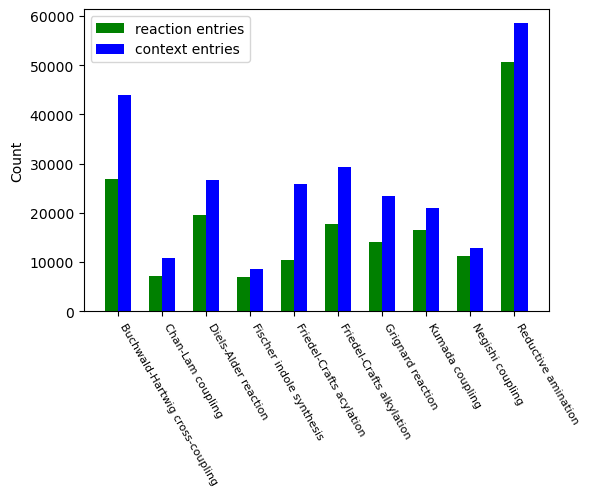

In [4]:
def reaction_entry(reaction_ids):
    now = '0'
    number = 0
    for id_ in reaction_ids:
        if id_ != now:
            number += 1
            now = id_
    return number

def data_distribution(records, reaction_name_convert_dict, save_path=None):
    reaction_names, entries = list(zip(*records.items()))
    reaction_names = [reaction_name_convert_dict[name] for name in reaction_names]
    reaction_entry, context_entry = list(zip(*entries))
    x = np.arange(len(reaction_names))
    width = 0.3
    plt.figure(dpi = 100)
    plt.bar(x, reaction_entry, width, color='green', label='reaction entries')
    plt.bar(x + width, context_entry, width, color='blue', label='context entries')
    plt.xticks(x + width / 2, reaction_names, rotation=-60, ha='left', fontsize=8)
    plt.ylabel('Count')
    plt.legend(bbox_to_anchor=(0,1), loc='upper left')
    # plt.show()
    if save_path:
        plt.savefig(save_path, format="svg", bbox_inches = "tight")

reaction_name_convert_dict = {
    "Buchwald-HartwigCross-Coupling": "Buchwald-Hartwig cross-coupling",
    "Chan_LamCoupling": "Chan-Lam coupling", 
    "DielsAlder": "Diels-Alder reaction",
    "FischerIndoleSynthesis": "Fischer indole synthesis",
    "Friedel-CraftsAcylation": "Friedel-Crafts acylation",
    "Friedel-CraftsAlkylation": "Friedel-Crafts alkylation",
    "GrignardReaction": "Grignard reaction",
    "KumadaCoupling": "Kumada coupling",
    "NegishiCoupling": "Negishi coupling",
    "ReductiveAmination": "Reductive amination",
}

print(records)
data_distribution(records, reaction_name_convert_dict, '../saved_figures/raw_data_distribution.svg')

In [5]:
# Prepare a dictionary to search what reaction a Reaction ID belongs to.
# ['Diels_Alder', 'Hydrolysis', 'Hydrogenation', 'ReductiveAmination','PausonKhandReaction', 'NegishiCouplings']

Reaction_ID_search = dict()
for reaction_name, data in raw_datas.items():
    for reaction_id in data['Reaction ID']:
        Reaction_ID_search.update({reaction_id: reaction_name})

print(len(Reaction_ID_search)) 
Reaction_ID_search['44835206']

180857


'ReductiveAmination'

In [6]:
def get_txt_data(input_path):
    f = open(input_path, 'r', encoding='UTF-8')
    data = f.readlines()
    f.close()
    return data

target_dir = "../data/reaxys_output"
train_data = get_txt_data(os.path.join(os.path.join(target_dir, 'For_second_part_model'), 'Splitted_second_train_labels_processed.txt'))
validate_data = get_txt_data(os.path.join(os.path.join(target_dir, 'For_second_part_model'), 'Splitted_second_validate_labels_processed.txt'))
test_data = get_txt_data(os.path.join(os.path.join(target_dir, 'For_second_part_model'), 'Splitted_second_test_labels_processed.txt'))

all_data = train_data + validate_data + test_data
all_data = [ line.strip('\n').split('\t')  for line in all_data]

print(all_data[0])
# Reaxys ID, reactant smiles, product smiles, yield, reagent, solvent, temperature
_, _, _, yields, reagents, solvents, temperatures = list(zip(*all_data))

yields = [float(y) for y in yields]

temperatures = [float(t)  for t in temperatures if not math.isnan(float(t)) ]
print(max(temperatures))
print(min(temperatures))

#### preprocess the temperature data
test_processed = [ line.strip('\n').split('\t')  for line in test_data]
train_processed = [ line.strip('\n').split('\t')  for line in train_data]
_, _, _, _, _, _, train_temperatures = list(zip(*train_processed))
_, _, _, _, _, _, test_temperatures = list(zip(*test_processed))

train_temperatures = [float(t)  for t in train_temperatures if not math.isnan(float(t)) ]
test_temperatures = [float(t)  for t in test_temperatures if not math.isnan(float(t))]

['8581089', 'O=C1C=CC(=O)C=C1.C=C1C(=C)[C@@]23COC4(CCCCC4)OC[C@@]12C(=C)C3=C', 'C=C1C(=C)[C@]23COC4(CCCCC4)OC[C@]12C1=C3CC2=C(C1)C(=O)C=CC2=O', '55', '2,3-dicyano-5,6-dichloro-p-benzoquinone', 'benzene', '65.0']
3120.0
-110.0


  0%|          | 0/93080 [00:00<?, ?it/s]

100%|██████████| 93080/93080 [00:00<00:00, 1199086.62it/s]


{'Buchwald-HartwigCross-Coupling': [11797, 18518], 'Chan_LamCoupling': [4556, 5770], 'DielsAlder': [7923, 8601], 'FischerIndoleSynthesis': [1229, 1354], 'Friedel-CraftsAcylation': [4905, 6824], 'Friedel-CraftsAlkylation': [8835, 12530], 'GrignardReaction': [7335, 8896], 'KumadaCoupling': [7762, 8753], 'NegishiCoupling': [5898, 6371], 'ReductiveAmination': [14443, 15463]}
Total reaction entries after preprocessed:  74683
Total context entries after preprocessed:  93080


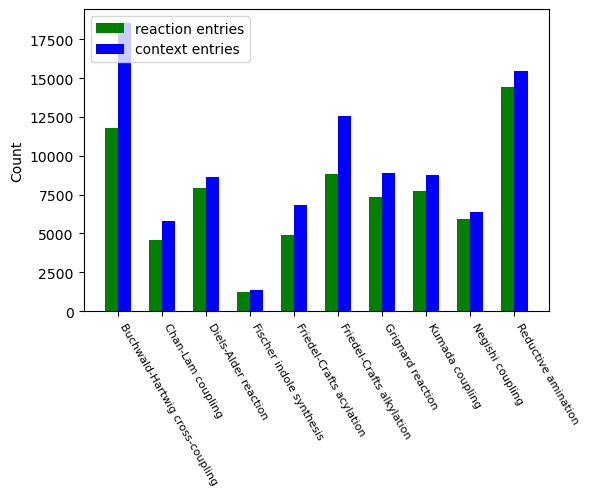

In [7]:
# Get the data distribution after all the data preprocessing
records_processed = {name: [0,0] for name in dir_names}
pre_reaxys_id = ''

for reaxys_id in tqdm(list(zip(*all_data))[0]):
    try:
        key = Reaction_ID_search[reaxys_id]
    except:
        #print(reaxys_id)
        continue
    #for key, value in raw_datas.items():
        #if reaxys_id in list(value['Reaction ID']):f
    records_processed[key][1] += 1
    if reaxys_id != pre_reaxys_id: records_processed[key][0] += 1
    pre_reaxys_id = reaxys_id

        

print(records_processed)
reaction_names_p, numbers_p = list(zip(*records_processed.items()))
reaction_entries_p, context_entries_p = zip(*numbers_p)
print("Total reaction entries after preprocessed: ", sum(reaction_entries_p))
print("Total context entries after preprocessed: ", sum(context_entries_p))

data_distribution(records_processed, reaction_name_convert_dict, '../saved_figures/processed_data_distribution.svg')

['Buchwald-Hartwig cross-coupling', 'Chan-Lam coupling', 'Diels-Alder reaction', 'Fischer indole synthesis', 'Friedel-Crafts acylation', 'Friedel-Crafts alkylation', 'Grignard reaction', 'Kumada coupling', 'Negishi coupling', 'Reductive amination']


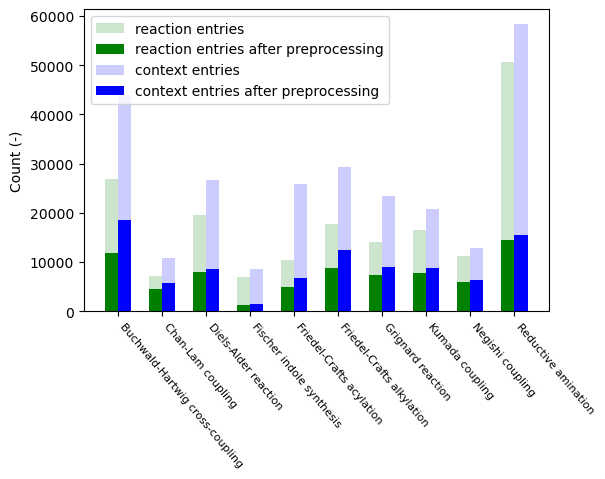

In [8]:
# print the joint distribution of data before and after data-preprocess
def joint_data_distribution(records, records_processed, reaction_name_convert_dict, save_path=None):
    reaction_names, entries = list(zip(*sorted(records.items())))
    reaction_entry, context_entry = list(zip(*entries))
    
    reaction_names, entries_processed = list(zip(*sorted(records_processed.items())))
    reaction_names = [reaction_name_convert_dict[name] for name in reaction_names]
    reaction_entry_processed, context_entry_processed = list(zip(*entries_processed))
    
    x = np.arange(len(reaction_names))
    width = 0.3
    plt.figure(dpi = 100)
    plt.bar(x, reaction_entry, width, color='green', label='reaction entries', alpha =0.2)
    plt.bar(x, reaction_entry_processed, width, color='green', label='reaction entries after preprocessing', alpha =1)
    
    plt.bar(x + width, context_entry, width, color='blue', label='context entries', alpha =0.2)
    plt.bar(x + width, context_entry_processed, width, color='blue', label='context entries after preprocessing', alpha =1)                                         
                                             
#     plt.xticks(x + width / 2, reaction_names, rotation=-50, ha='left')
    print(reaction_names)
    plt.xticks(x + width / 2, reaction_names, rotation=-50, ha='left', fontsize=8)
    plt.ylabel('Count (-)')
    plt.legend(bbox_to_anchor=(0,1), loc='upper left')
    if save_path:
        plt.savefig(save_path, format="svg", bbox_inches = "tight")
                                             
joint_data_distribution(records, records_processed, reaction_name_convert_dict, save_path="../saved_figures/joint_data_distribution.svg")

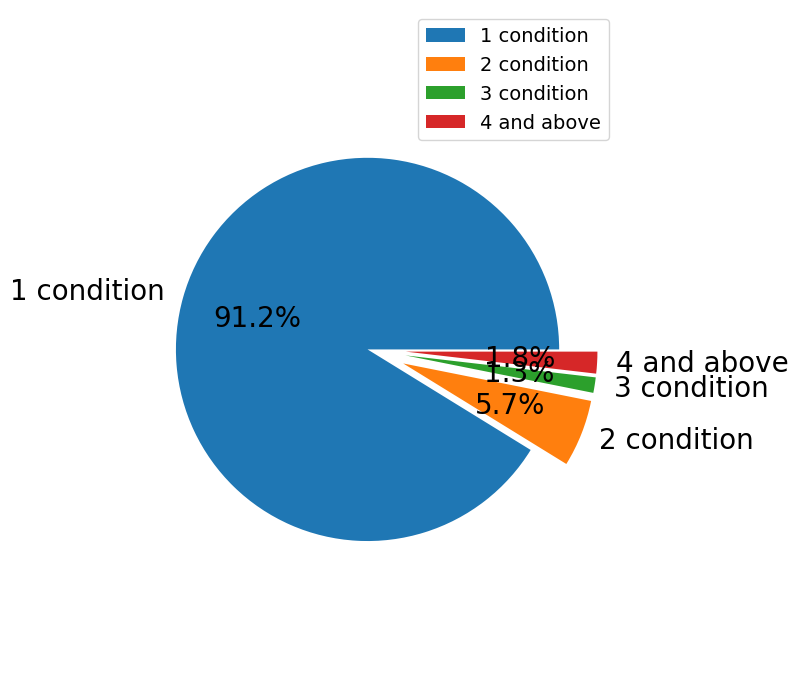

In [17]:
# Check the multiple reaction context entries
def sort_out_data(data):
    sorted_data = []
    rxn_id = ''
    j = -1
    for i in range(len(data)):
        if rxn_id != data[i][0]:
            j += 1
            sorted_data.append([data[i][0], data[i][1], data[i][2], []])
            y_ = data[i][3]; r_ = remove_duplicated_records(data[i][4]);
            s_ = remove_duplicated_records(data[i][5]); t_ = data[i][6];
            sorted_data[j][3].append((y_, r_, s_, t_))
            rxn_id = data[i][0]
        else:
            if (r_ == remove_duplicated_records(data[i][4])) & (s_ == remove_duplicated_records(data[i][5])):
                pass
            else:
                y_ = data[i][3]; r_ = remove_duplicated_records(data[i][4]);
                s_ = remove_duplicated_records(data[i][5]); t_ = data[i][6];
                sorted_data[j][3].append((y_, r_, s_, t_))
    return sorted_data

def remove_duplicated_records(records):
    return '; '.join(list(dict.fromkeys(records.split('; '))))

def cum_sum_dict(results, start):
    record = dict()
    above = 0
    for key, value in results.items():
        if key < start:
            record[str(key)+' condition'] = value
        else:
            above += value
    record[str(start)+' and above'] = above
    return record


data_sorted = sort_out_data(all_data)
conditions = []
for i, rxn in enumerate(data_sorted):
    context = rxn[3]
    conditions.append(len(context))
results = Counter(conditions)
pie_data = cum_sum_dict(results, 4)

plt.figure(figsize=(6,9), dpi =100)    # 顯示圖框架大小
labels, size = list(zip(*sorted(pie_data.items())))      # 製作圓餅圖的類別標籤
separeted = (0, 0.2, 0.2, 0.2)                  # 依據類別數量，分別設定要突出的區塊
# size = accident["count"]                         # 製作圓餅圖的數值來源

plt.pie(size,                           # 數值
        labels = labels,                # 標籤
        autopct = "%1.1f%%",            # 將數值百分比並留到小數點一位
        explode = separeted,            # 設定分隔的區塊位置
        pctdistance = 0.6,              # 數字距圓心的距離
        textprops = {"fontsize" : 20},  # 文字大小
        shadow=False)                    # 設定陰影

plt.axis('equal')                                          # 使圓餅圖比例相等
# plt.title("Pie chart of number of reaction conditions", {"fontsize" : 18})  # 設定標題及其文字大小
plt.legend(loc = "best",fontsize = 14)
plt.savefig("../saved_figures/pie_chart.svg", format="svg", bbox_inches = "tight")

mean=44.5°C, median=20.0°C


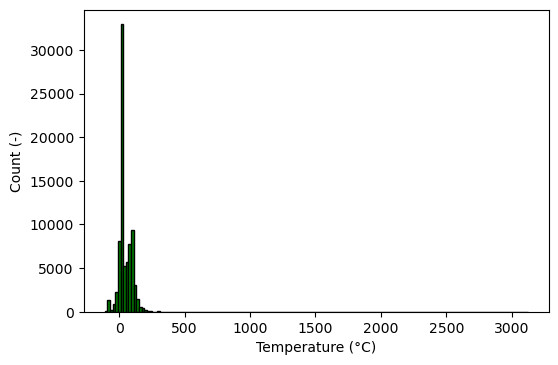

In [10]:
# Temperature histogram 1
plt.figure(dpi=100)
plt.hist(temperatures, color = 'green', edgecolor = 'black',
         bins = int((max(temperatures) - min(temperatures))//20))
# plt.title('Temperature distribution')
print('mean={:.1f}\u00b0C, median={:.1f}\u00b0C'.format(np.mean(temperatures), np.median(temperatures)))
plt.xlabel('Temperature (\u00b0C)')
plt.ylabel('Count (-)')
plt.savefig("../saved_figures/temperature_distribution_1.svg", format="svg", bbox_inches = "tight")

mean=44.2°C, median=20.0°C


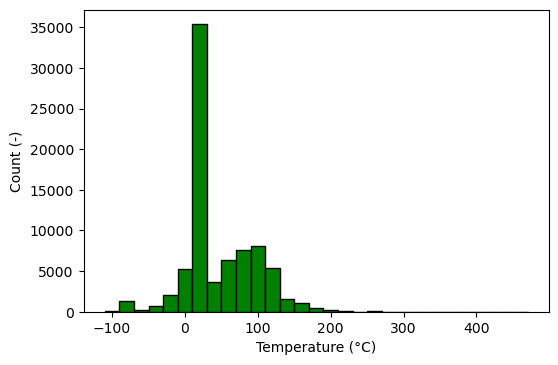

In [11]:
# Temperature histogram 2 (excludue temperature > 300)
temperatures_2 = [float(t)  for t in temperatures if float(t) <=501.]
plt.figure(dpi=100)
plt.hist(temperatures_2, color = 'green', edgecolor = 'black',
         bins = int((max(temperatures_2) - min(temperatures_2))//20))

# plt.title('Temperature distribution)
print('mean={:.1f}\u00b0C, median={:.1f}\u00b0C'.format(np.mean(temperatures_2), np.median(temperatures_2)))
plt.xlabel('Temperature (\u00b0C)')
plt.ylabel('Count (-)')
plt.savefig("../saved_figures/temperature_distribution_2.svg", format="svg", bbox_inches = "tight")

In [13]:
# Calcluate the accuracy of tempreature basline:
# Use the mean and median of training data as baslines, and then evaluate the performance on testing data
def accuracy_within_range(temp_diffs, span):
    acc = [1 if (np.abs(t) <= span) else 0 for t in temp_diffs ]
    return sum(acc)/len(acc)

mean_temp = np.mean(train_temperatures)
median_temp = np.median(train_temperatures)
mean_diffs = [(t - mean_temp) for t in test_temperatures]
median_diffs = [(t - median_temp) for t in test_temperatures]
span1 = 10
span2 = 20

print('Mean temperature ({:.1f}\u00b0C) baseline:'.format(mean_temp))
print('RMSE of mean temperature: {:.1f}'.format(np.sqrt(np.average(np.square(mean_diffs)))))
print('MAE of mean temperature: {:.1f}'.format(np.average(np.abs(mean_diffs))))
print('Mean temperature predictions fall within +-{}\u00b0C accuracy: {:.1f}%'.format(
    span1, 100*accuracy_within_range(mean_diffs, span1))) 
print('Mean temperature predictions fall within +-{}\u00b0C accuracy: {:.1f}%'.format(
    span2, 100*accuracy_within_range(mean_diffs, span2)))

print('-'*50)
print('Median temperature ({:.1f}\u00b0C) baseline:'.format(median_temp))
print('RMSE of median temperature: {:.1f}'.format(np.sqrt(np.average(np.square(median_diffs)))))
print('MAE of median temperature: {:.1f}'.format(np.average(np.abs(median_diffs))))
print('Median temperature predictions fall within +-{}\u00b0C accuracy: {:.1f}%'.format(
    span1, 100*accuracy_within_range(median_diffs, span1))) 
print('Median temperature predictions fall within +-{}\u00b0C accuracy: {:.1f}%'.format(
    span2, 100*accuracy_within_range(median_diffs, span2)))
    

Mean temperature (44.6°C) baseline:
RMSE of mean temperature: 49.8
MAE of mean temperature: 38.4
Mean temperature predictions fall within +-10°C accuracy: 6.2%
Mean temperature predictions fall within +-20°C accuracy: 16.5%
--------------------------------------------------
Median temperature (20.0°C) baseline:
RMSE of median temperature: 55.1
MAE of median temperature: 34.4
Median temperature predictions fall within +-10°C accuracy: 46.5%
Median temperature predictions fall within +-20°C accuracy: 55.6%


mean=70.4%, median=76.0%


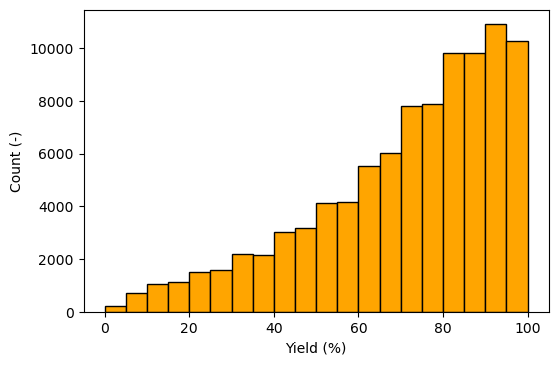

In [26]:
# Yield histogram
plt.figure(dpi=100)
plt.hist(yields, color = 'orange', edgecolor = 'black',
         bins = 20)

# plt.title('Yield distribution')
print('mean={:.1f}%, median={:.1f}%'.format(np.mean(yields), np.median(yields)))
plt.xlabel('Yield (%)')
plt.ylabel('Count (-)')
plt.savefig("../saved_figures/yield_distribution.svg", format="svg", bbox_inches = "tight")

Number of reagent classes: 1320
Number of solvent classes: 87


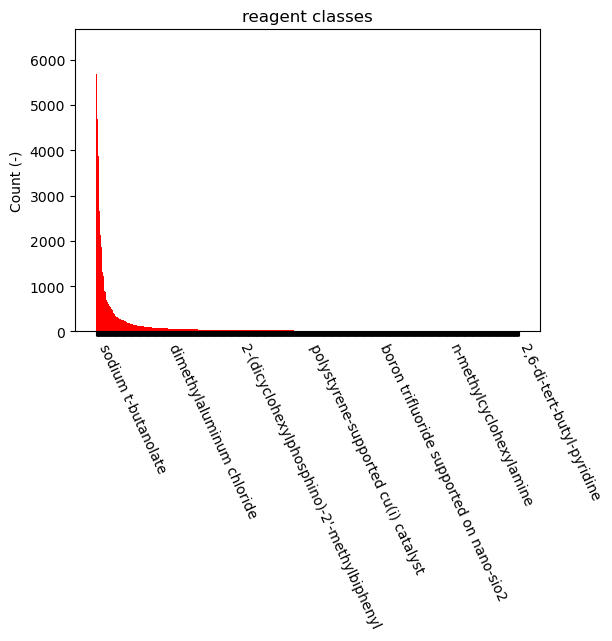

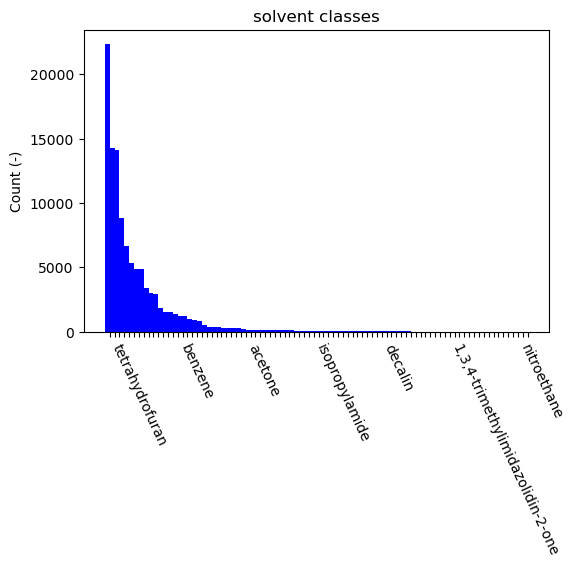

In [30]:
# Visualize reagent and solvent classes distribution
def plot_classes(classes_list, title = '', color = 'r', save_path=None):
    names, counts = zip(*classes_list)
    show = len(names)//6
    names = [n.lower() if ((i+1)%show == 1) else '' for i, n in enumerate(names) ]
    pos = np.arange(len(names))
    width = 1.0
    plt.figure(dpi=100)
    ax = plt.axes()
    ax.set_xticks(pos + (width / 2))
    ax.set_xticklabels(names, rotation=-65, ha='left')
    plt.ylabel('Count (-)')
    # plt.xlabel('class name')
    plt.title(title)
    plt.bar(pos, counts, width, color=color)
    if save_path:
        plt.savefig(save_path, format="svg", bbox_inches = "tight")

reag_list = []; solv_list = [];
for reagent, solvent in zip(reagents, solvents):
    reag_list += reagent.split('; ')
    solv_list += solvent.split('; ')
reag_list = list(Counter(reag_list).items())
reag_list = sorted(reag_list, key=lambda x:x[1], reverse=True)
solv_list = list(Counter(solv_list).items())
solv_list = sorted(solv_list, key=lambda x:x[1], reverse=True)

plot_classes(reag_list[1:], title = 'reagent classes', color = 'r', save_path = "../saved_figures/reagent_class.svg")
plot_classes(solv_list, title = 'solvent classes', color = 'b', save_path = "../saved_figures/solvent_class.svg")
print("Number of reagent classes: {}".format(len(reag_list)))
print("Number of solvent classes: {}".format(len(solv_list)))

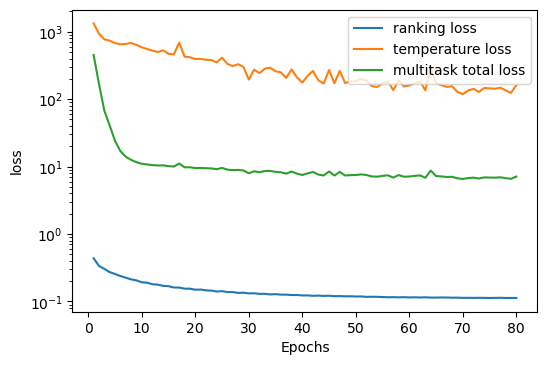

In [37]:
def plot_summary(epoch_dict, labels, ylabel, color = 'b'):
    plt.figure(dpi=100)
    for label in labels:
        keys = []
        sub_values = []
        for key, value in epoch_dict.items():
            keys.append(key)
            sub_values.append(epoch_dict[key][label])
        plt.plot(keys, sub_values, label=label)
    plt.xlabel('Epochs')
    plt.ylabel(ylabel)
    plt.yscale('log')
    plt.legend()
    # plt.show()

log_path = os.path.join(target_dir, 'log_second.txt')
f = open(log_path, 'r')
train_log = f.readlines()
f.close()
epoch_dict = dict()
for i, line in enumerate(train_log):
    if 'epoch: ' in line:
        number = int(line.strip('\n').split(': ')[-1])
        epoch_dict[number] = dict()
        epoch_dict[number]['ranking loss'] = float(train_log[i+1].strip('\n').split(': ')[-1])
        epoch_dict[number]['temperature loss'] = float(train_log[i+2].strip('\n').split(': ')[-1])
        epoch_dict[number]['multitask total loss'] = float(train_log[i+3].strip('\n').split(': ')[-1])
        epoch_dict[number]['log variance of ranking task'] = float(train_log[i+4].strip('\n').split(': ')[-1])
        epoch_dict[number]['log variance of temperature task'] = float(train_log[i+5].strip('\n').split(': ')[-1])

plot_summary(epoch_dict, ['ranking loss', 'temperature loss', 'multitask total loss'], 'loss', color = 'y')
#plot_summary(epoch_dict, ['log variance of temperature task'], 'loss', color = 'y')